In [1]:
from setup_env import setup_environment

setup_environment()

In [2]:
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from project.wfc.factory import Factory
from project.wfc.grid import Grid, Rect
from project.wfc.judge import RandomJudge, Judge
from project.config import DATA_SOURCE
from project.wfc.wfc import WFC
from project.machine_learning.model_mc import ModelMC

In [3]:
sns.set_style("whitegrid")
sns.set_context("paper")

In [4]:
factory = Factory(DATA_SOURCE)
patterns = factory.create_patterns()

INFO - Validation Result: success



In [5]:
def evaluate_wfc(
    sizes: np.ndarray, target_successes: int, judge: Judge, name: str
) -> pd.DataFrame:
    results = []

    for size in tqdm(sizes):
        rect = Rect(width=size, height=size)
        grid = Grid(rect=rect, patterns=patterns)
        wfc = WFC(grid=grid, judge=judge)

        successes = 0
        tries = 0

        while successes < target_successes:
            is_succeeded = False

            while not is_succeeded:
                tries += 1
                is_succeeded = wfc.generate()

            successes += 1

        mean_tries = tries / target_successes
        results.append({"model": name, "size": size**2, "mean_tries": mean_tries})

    return pd.DataFrame(results)

In [6]:
sizes = np.arange(2, 11)
target_successes = 100

In [7]:
random_judge = RandomJudge()

wfc_df = evaluate_wfc(sizes, target_successes, random_judge, "WFC")

wfc_df.head(5)

100%|██████████| 9/9 [00:22<00:00,  2.50s/it]


model  size  mean_tries
0   WFC     4        1.01
1   WFC     9        1.01
2   WFC    16        1.25
3   WFC    25        1.51
4   WFC    36        1.91

In [8]:
mc_judge = ModelMC(view=Rect(3, 3))
mc_judge.load_weights("data/weights/wfcwmc/mmc_1000")

wfcwmc_df = evaluate_wfc(sizes, target_successes, mc_judge, "WFCWMC")

wfcwmc_df.head(5)

100%|██████████| 9/9 [00:09<00:00,  1.04s/it]


model  size  mean_tries
0  WFCWMC     4        1.00
1  WFCWMC     9        1.02
2  WFCWMC    16        1.06
3  WFCWMC    25        1.08
4  WFCWMC    36        1.16

In [9]:
evaluation_df = pd.concat([wfc_df, wfcwmc_df]).reset_index(drop=True)

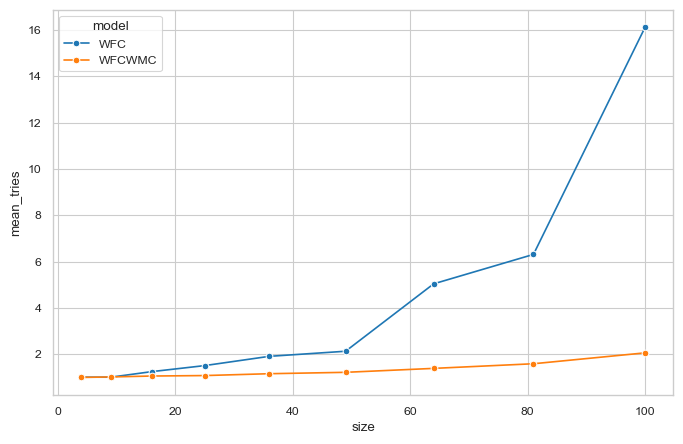

In [10]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=evaluation_df, x="size", y="mean_tries", hue="model", marker="o")
plt.savefig("content/performance.png", bbox_inches="tight")